In [2]:
import numpy as np
import cmocean as cmo
import os
import yaml
import pandas as pd
import copy
import functools
from collections import OrderedDict
from matplotlib.lines import Line2D
import copy

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})

rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

palette = sns.color_palette("colorblind")

<ipython-input-3-d5227da0881e>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'


In [4]:
color_1 = [33/255, 120/255, 68/255]
color_2 = [0/255, 170/255, 212/255]
color_3 = [135/255, 222/255, 170/255]

## Sec 6

In [38]:
big_df = pd.read_csv("results_combined_v3.csv")
# big_df["gan_ratio"].unique()

In [39]:
big_df.keys()

Index(['Unnamed: 0', 'level_0', 'Unnamed: 0.1', 'index', 'trial_id',
       'teacher_aug_train_accuracy', 'teacher_aug_train_nll',
       'teacher_aug_train_ece', 'teacher_train_accuracy', 'teacher_train_nll',
       'teacher_train_ece', 'teacher_aug_test_accuracy',
       'teacher_aug_test_nll', 'teacher_aug_test_ece', 'teacher_test_accuracy',
       'teacher_test_nll', 'teacher_test_ece', 'student_aug_train_accuracy',
       'student_aug_train_nll', 'student_aug_train_ece',
       'student_train_accuracy', 'student_train_nll', 'student_train_ece',
       'student_aug_test_accuracy', 'student_aug_test_nll',
       'student_aug_test_ece', 'student_test_accuracy', 'student_test_nll',
       'student_test_ece', 'aug_train_kl_ts', 'aug_train_kl_st',
       'aug_train_sym_kl', 'aug_train_matching', 'train_kl_ts', 'train_kl_st',
       'train_sym_kl', 'train_matching', 'aug_test_kl_ts', 'aug_test_kl_st',
       'aug_test_sym_kl', 'aug_test_matching', 'test_kl_ts', 'test_kl_st',
       'test

In [41]:
big_df = pd.read_csv("results_combined_v3.csv")


masks = OrderedDict()
masks["Baseline"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]",
        "gan_ratio": "Not Specified"
    }
masks[r"Baseline($T=4$)"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 4.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks["Rotation"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "rotation,crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks["Vertical Flip"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "vertical_flip,crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks["ColorJitter"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "colorjitter,crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks["Combined Augs"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "rotation,vertical_flip,colorjitter,crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks["MixUp"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": True,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks[r"MixUp($T=4$)"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": True,
        "temperature": 4.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"
    }
masks[r"GAN($T=4$)"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "gan_ratio": '0.2'
}
# masks["GAN(0.4)"] = {
#         "teacher_depth": 56,
#         "classifier_depth": 56,
#         "gan_ratio": '0.4'
# }
# masks["GAN(0.8)"] = {
#         "teacher_depth": 56,
#         "classifier_depth": 56,
#         "gan_ratio": '0.8'
# }
masks["OOD"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "dataset": "cifar100_svhn",
        "tensor_augmentations": "[]"
    }
masks["Noise"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "tensor_augmentations": "replace_with_uniform"
    }

In [508]:
metrics = OrderedDict()
metrics["Accuracy"] = "student_test_accuracy"
metrics["NLL"] = "student_test_nll"
metrics["Agreement"] = "test_matching"
metrics[r"$KL(T \vert\vert S)$"] = "test_kl_ts"

df = []
for j, (exp_name, mask_dict) in enumerate(masks.items()):
    mask_dict.update({"teacher_num_components": 5})
    mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
        True)
    masked_results = big_df[mask]
    print("Number of trials:", len(masked_results))
    mean = masked_results.mean().to_frame().T
    mean["name"] = exp_name
    if j == 0:
        df = mean[["name", "teacher_test_accuracy", "teacher_test_nll", *metrics.values()]]
    else:
        df = df.append(mean[["name", "teacher_test_accuracy", *metrics.values()]])
df = df.reset_index()

Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3
Number of trials: 3


In [509]:
df[["name", "student_test_accuracy"]]

name  student_test_accuracy
0          Baseline               0.724633
1   Baseline($T=4$)               0.748733
2          Rotation               0.734900
3     Vertical Flip               0.741367
4       ColorJitter               0.746300
5     Combined Augs               0.732967
6             MixUp               0.750633
7      MixUp($T=4$)               0.748433
8        GAN($T=4$)               0.750267
9               OOD               0.726300
10            Noise               0.713533

<ipython-input-512-7a6c167532ba>:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  arr[i].set_xticks([], [])


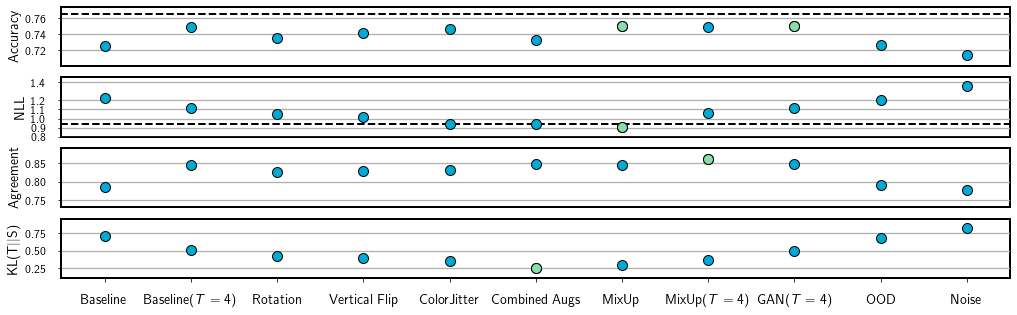

In [512]:
metrics = OrderedDict()
metrics["Accuracy"] = "student_test_accuracy"
metrics["NLL"] = "student_test_nll"
metrics["Agreement"] = "test_matching"
metrics[r"KL(T$\vert\vert$S)"] = "test_kl_ts"

f, arr = plt.subplots(len(metrics), 1, figsize=(17, 5))

xs = range(len(masks))
for i, metric_df_name in enumerate(metrics.values()):
    arr[i].plot(xs, df[metric_df_name], "o", c=color_2, ms=10, mec="k")

for i, (metric_plot_name, _) in enumerate(metrics.items()):
    arr[i].set_ylabel(metric_plot_name, fontsize=14)
    arr[i].tick_params(axis='y', which='major', labelsize=12)
    arr[i].set_xticks([], [])
    arr[i].grid(True, axis="y")
    arr[i].patch.set_edgecolor('black')
    arr[i].patch.set_linewidth('2') 
    
arr[-1].set_xticks(range(len(masks)))
arr[-1].set_xticklabels(masks, fontsize=14)

arr[0].set_yticks([0.72, 0.74, 0.76])
arr[1].set_yticks([0.8, 0.9, 1., 1.1, 1.2, 1.4])

arr[0].set_ylim(0.70, 0.775)
arr[1].set_ylim(0.8, 1.455)
arr[2].set_ylim(0.73, 0.89)
arr[3].set_ylim(0.1, 0.95)

arr[0].plot([6], df["student_test_accuracy"][6], "o", c=color_3, ms=10, mec="k", mew=1)
arr[0].plot([8], df["student_test_accuracy"][8], "o", c=color_3, ms=10, mec="k", mew=1)
arr[1].plot([6], df["student_test_nll"][6], "o", c=color_3, ms=10, mec="k", mew=1)
arr[2].plot([7], df["test_matching"][7], "o", c=color_3, ms=10, mec="k", mew=1)
arr[3].plot([5], df["test_kl_ts"][5], "o", c=color_3, ms=10, mec="k", mew=1)

arr[0].hlines(df["teacher_test_accuracy"][0], -1, 12, "k", linestyle="dashed", lw=2)
arr[1].hlines(df["teacher_test_nll"][0], -1, 12, "k", linestyle="dashed", lw=2)

for i, _ in enumerate(metrics.items()):
    arr[i].set_xlim(-0.5, 10.5)

plt.savefig("augmentation_comparison.pdf", bbox_inches="tight")

## Detailed Plots

In [54]:
big_df

Unnamed: 0  level_0  Unnamed: 0.1  index  trial_id  \
0             0        0           0.0    0.0         1   
1             1        1           1.0    1.0         3   
2             2        2           2.0    2.0         2   
3             3        3           3.0    3.0         1   
4             4        4           4.0    4.0         3   
..          ...      ...           ...    ...       ...   
158         158        7           NaN    NaN         2   
159         159        8           NaN    NaN         0   
160         160        9           NaN    NaN         1   
161         161       10           NaN    NaN         2   
162         162       11           NaN    NaN         0   

     teacher_aug_train_accuracy  teacher_aug_train_nll  teacher_aug_train_ece  \
0                       0.99982               0.009090               0.008550   
1                       0.99988               0.008644               0.008162   
2                       0.99980               0.008758               0.008160   
3                       0.98892               0.163878               0.116440   
4                       0.98856               0.164291               0.115858   
..                          ...                    ...                    ...   
158                     0.99974               0.008708               0.008139   
159                     0.99982               0.008871               0.008361   
160                     0.99984               0.008660               0.008195   
161                     0.99984               0.008711               0.008285   
162                     0.99982               0.008901               0.008373   

     teacher_train_accuracy  teacher_train_nll  ...  synth_ratio  \
0                   0.99978           0.006376  ...          0.0   
1                   0.99982           0.005997  ...          0.0   
2                   0.99982           0.006101  ...          0.0   
3                   0.98902           0.136004  ...          0.0   
4                   0.98898           0.137436  ...          0.0   
..                      ...                ...  ...          ...   
158                 0.99982           0.005905  ...          0.0   
159                 0.99980           0.006205  ...          0.0   
160                 0.99980           0.006074  ...          0.0   
161                 0.99982           0.005905  ...          0.0   
162                 0.99980           0.006205  ...          0.0   

     retempering_T  subsample_split  subsample_seed  loss_alpha  \
0              1.0    Not specified   Not specified         0.0   
1              1.0    Not specified   Not specified         0.0   
2              1.0    Not specified   Not specified         0.0   
3              1.0    Not specified   Not specified         0.0   
4              1.0    Not specified   Not specified         0.0   
..             ...              ...             ...         ...   
158            1.0                0               0         0.0   
159            1.0                0               0         0.0   
160            1.0                0               0         0.0   
161            1.0                0               0         0.0   
162            1.0                0               0         0.0   

      distill_temp  num_epochs      gan_ratio  subsample_ratio  \
0    Not specified         300  Not Specified              NaN   
1    Not specified         300  Not Specified              NaN   
2    Not specified         300  Not Specified              NaN   
3    Not specified         300  Not Specified              NaN   
4    Not specified         300  Not Specified              NaN   
..             ...         ...            ...              ...   
158            4.0         300            0.2              1.0   
159            4.0         300            0.2              1.0   
160            4.0         300            0.6              1.0   
161            4.0         300           

In [100]:
metrics = OrderedDict()
metrics["Accuracy"] = "student_test_accuracy"
metrics["NLL"] = "student_test_nll"
metrics["ECE"] = "student_test_ece"
metrics["Agreement"] = "test_matching"
metrics["Baseline Agreement"] = "baseline_test_matching"
metrics[r"$KL(T \vert\vert S)$"] = "test_kl_ts"
metrics[r"Baseline $KL(T \vert\vert S)$"] = "baseline_test_kl_ts"

df = []
for j, (exp_name, mask_dict) in enumerate(masks.items()):
#     mask_dict.update({"teacher_num_components": 5})
    mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
        True)
    masked_results = big_df[mask]
    print("Number of trials:", len(masked_results))
    mean = masked_results.groupby("teacher_num_components").mean().reset_index()
    mean["name"] = exp_name
    if j == 0:
        df = mean[["name", "teacher_num_components", "teacher_test_accuracy", "teacher_test_nll", "teacher_test_ece", *metrics.values()]]
    else:
        df = df.append(mean[["name", "teacher_num_components", "teacher_test_accuracy", "teacher_test_nll", "teacher_test_ece", *metrics.values()]])
df = df.reset_index()

Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 3
Number of trials: 9
Number of trials: 9


In [128]:
def make_plot(df, metric, 
              is_performance, with_teacher, with_baseline,
              student_color=color_1, teacher_color=color_2, baseline_color=color_3):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    
    
    if is_performance:
        model_color_list = [["student", "-o", student_color, "Student"]]
        if with_teacher:
            model_color_list.append(["teacher", "--o", "k", "Teacher"])
        for model, line, color, label in model_color_list:

            ax.plot([1, 3, 5], df["{}_{}".format(model, metric)], line, 
                    ms=15, mec="k", lw=4, color=color, label=label)
    else:
        model_color_list = [["", student_color, "Student"]]
        if with_baseline:
            model_color_list.append(["baseline_", baseline_color, "Ind Baseline"])
        for model, color, label in model_color_list:
            actual_metric = "{}{}".format(model, metric)
            ax.plot([1, 3, 5], df[actual_metric], "-o", ms=15, mec="k",
                     lw=4, color=color, label=label)
    
    ax.set_xlabel("Teacher size", fontsize=18)
    ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
    ax.grid(True)
    return ax
        

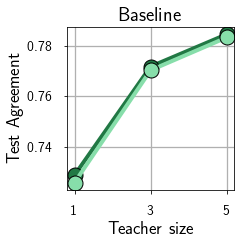

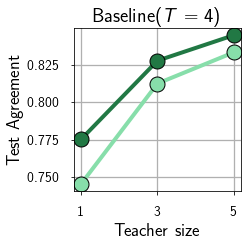

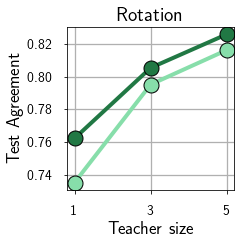

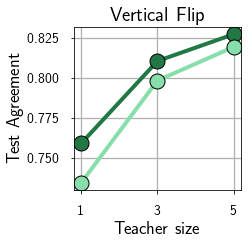

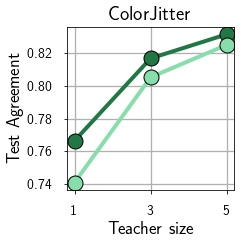

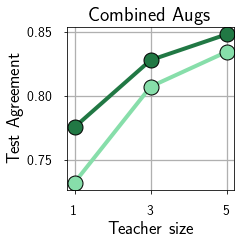

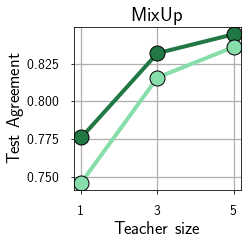

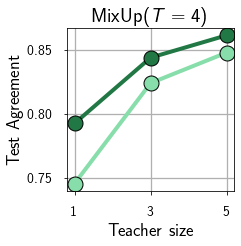

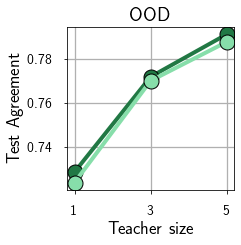

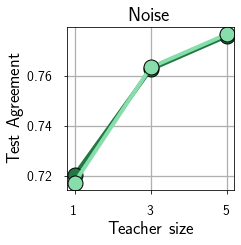

In [120]:
for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    ax = make_plot(df[df["name"]==name], "test_matching", is_performance=False, with_teacher=False, with_baseline=True)
    ax.set_ylabel("Test Agreement", fontsize=18)
    ax.set_title(name, fontsize=20)
    plt.savefig("supp_augs_{}_agreement.pdf".format(name), bbox_inches="tight")

handles1 = ax.get_legend_handles_labels()

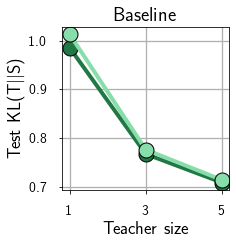

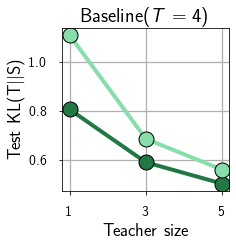

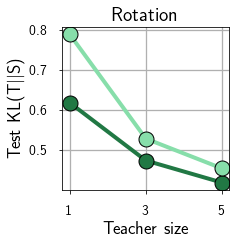

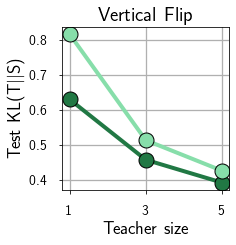

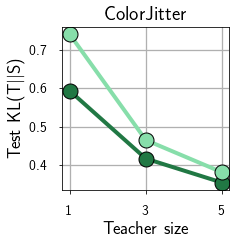

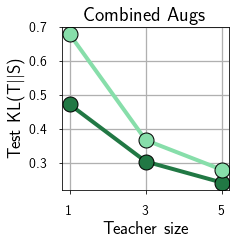

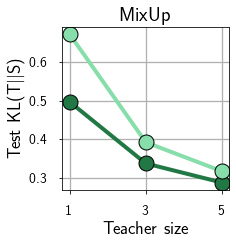

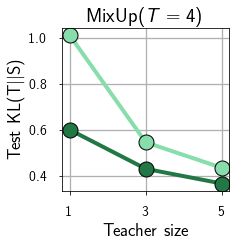

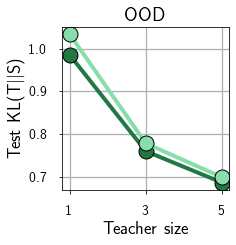

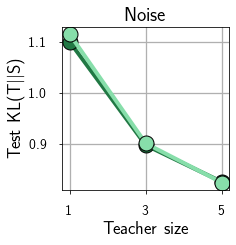

In [114]:
for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    ax = make_plot(df[df["name"]==name], "test_kl_ts", is_performance=False, with_teacher=False, with_baseline=True)
    ax.set_ylabel(r"Test KL(T$\vert\vert$S)", fontsize=18)
    ax.set_title(name, fontsize=20)
    plt.savefig("supp_augs_{}_kl.pdf".format(name), bbox_inches="tight")

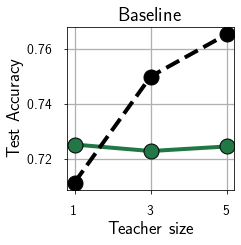

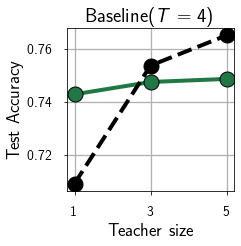

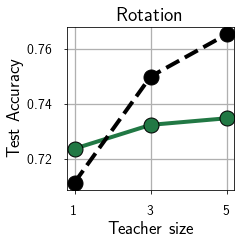

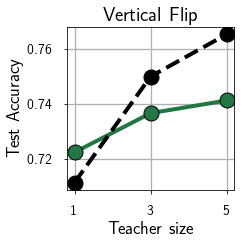

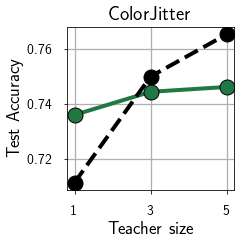

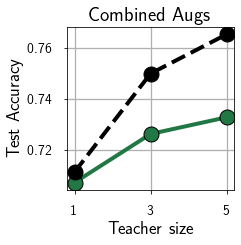

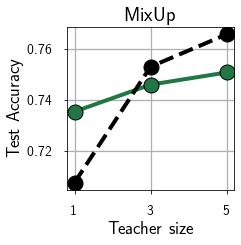

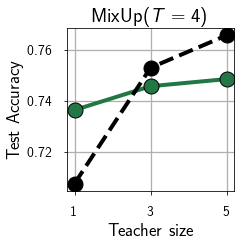

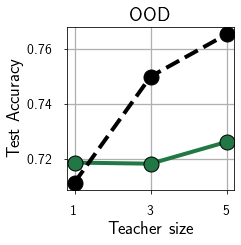

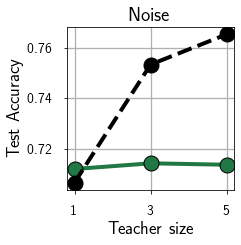

In [129]:
for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    ax = make_plot(df[df["name"]==name], "test_accuracy", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test Accuracy", fontsize=18)
    ax.set_title(name, fontsize=20)
    plt.savefig("supp_augs_{}_acc.pdf".format(name), bbox_inches="tight")

handles2 = ax.get_legend_handles_labels()

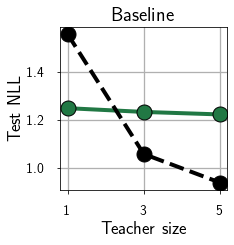

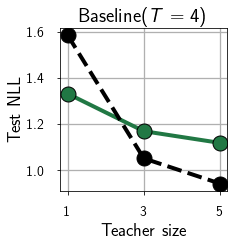

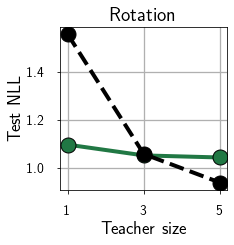

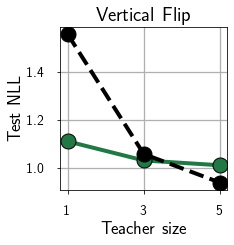

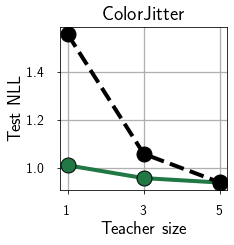

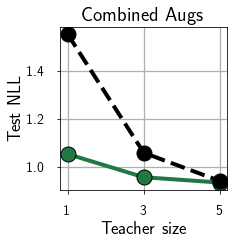

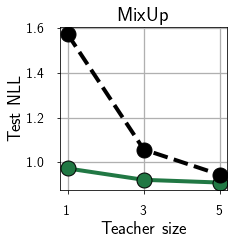

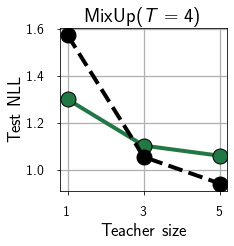

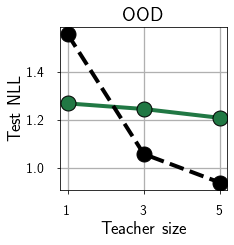

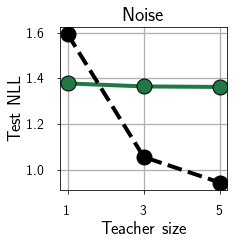

In [116]:
for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    ax = make_plot(df[df["name"]==name], "test_nll", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test NLL", fontsize=18)
    ax.set_title(name, fontsize=20)
    plt.savefig("supp_augs_{}_nll.pdf".format(name), bbox_inches="tight")

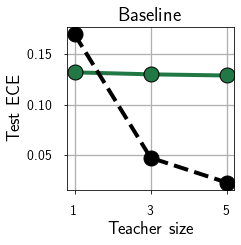

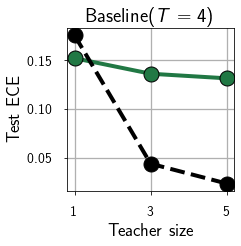

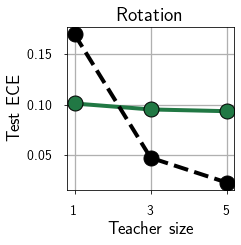

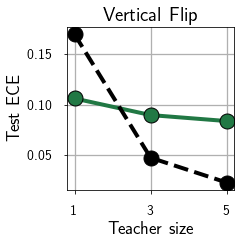

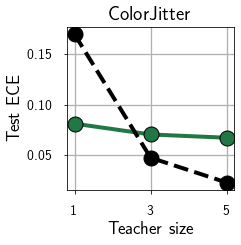

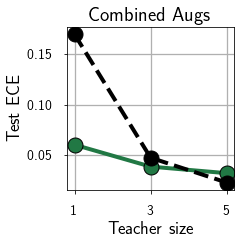

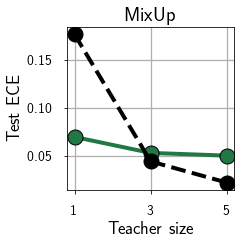

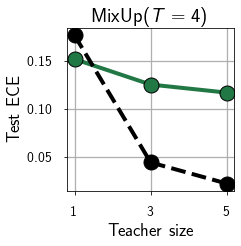

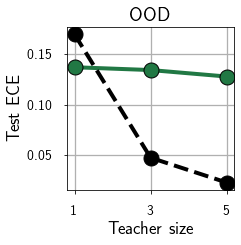

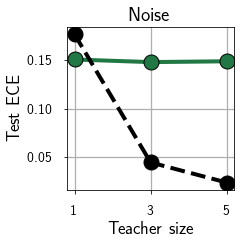

In [117]:
for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    ax = make_plot(df[df["name"]==name], "test_ece", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test ECE", fontsize=18)
    ax.set_title(name, fontsize=20)
    plt.savefig("supp_augs_{}_ece.pdf".format(name), bbox_inches="tight")

In [130]:
handles2x

([<matplotlib.lines.Line2D at 0x7ff487e35400>,
 ['Student', 'Teacher'])

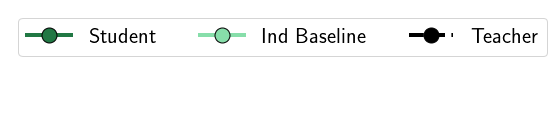

In [132]:
handles = ([*handles1[0], handles2[0][1]], [*handles1[1], handles2[1][1]])
figlegend = plt.figure(figsize=(2,2))
plt.legend(*handles, 
           loc ='upper left',
           fontsize=22,
           ncol=4
          )
plt.axis("off")
plt.savefig("supp_augs_legend.pdf", bbox_inches="tight")

In [133]:
agree_str = "\includegraphics[height=0.12\\textwidth]{{figures/supp_augs_{}_agreement.pdf}} &"
kl_str = "\includegraphics[height=0.12\\textwidth]{{figures/supp_augs_{}_kl.pdf}}"
acc_str = "\includegraphics[height=0.12\\textwidth]{{figures/supp_augs_{}_acc.pdf}} &"
nll_str = "\includegraphics[height=0.12\\textwidth]{{figures/supp_augs_{}_nll.pdf}} &"
ece_str = "\includegraphics[height=0.12\\textwidth]{{figures/supp_augs_{}_ece.pdf}} &"


for name in df["name"].unique():
    if name == "GAN($T=4$)":
        continue
    print(acc_str.format(name))
    print(nll_str.format(name))
    print(ece_str.format(name))
    print(agree_str.format(name))
    print(kl_str.format(name))
    print("\\\\[-0.2cm]")
    

print(r"\multicolumn{5}{c}{\includegraphics[height=0.07\textwidth]{figures/supp_augs_legend}}")
print("\\\\[-0.2cm]")  

\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline_acc.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline_nll.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline_ece.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline_agreement.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline_kl.pdf}
\\[-0.2cm]
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline($T=4$)_acc.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline($T=4$)_nll.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline($T=4$)_ece.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline($T=4$)_agreement.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Baseline($T=4$)_kl.pdf}
\\[-0.2cm]
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Rotation_acc.pdf} &
\includegraphics[height=0.12\textwidth]{figures/supp_augs_Rotation_nll.pdf} &
\

In [77]:
df["name"].unique()

array(['Baseline', 'Baseline($T=4$)', 'Rotation', 'Vertical Flip',
       'ColorJitter', 'Combined Augs', 'MixUp', 'MixUp($T=4$)',
       'GAN($T=4$)', 'OOD', 'Noise'], dtype=object)

In [58]:
df[df["name"]=="Baseline"]

index      name  teacher_num_components  teacher_test_accuracy  \
0      0  Baseline                       1               0.711500   
1      1  Baseline                       3               0.750100   
2      2  Baseline                       5               0.765467   

   teacher_test_nll  student_test_accuracy  student_test_nll  test_matching  \
0          1.555128               0.725333          1.249413       0.728667   
1          1.059665               0.722967          1.233879       0.771900   
2          0.941697               0.724633          1.223561       0.784733   

   baseline_test_matching  test_kl_ts  baseline_test_kl_ts  
0                0.725717    0.985295             1.012875  
1                0.770417    0.767683             0.776633  
2                0.783467    0.709240             0.714665

## Tractable Distributions

In [336]:
big_df = pd.read_csv("tractable_distribution.csv")

In [337]:
masks =[
    {
        "teacher_depth": 20,
        "classifier_depth": 20,
        "mixup_used": False,
        "temperature": 1.,
        "dataset": "cifar100",
    },
    {
        "teacher_depth": 20,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "dataset": "cifar100",
    },
]

In [338]:
def make_plot(df, mask_dict, metric, 
              is_performance, with_teacher, with_baseline,
              student_color=color_1, teacher_color=color_2, baseline_color=color_3):
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    
    mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
        True)
    masked_results = big_df[mask]
    print("Number of trials:", len(masked_results))
    
    if is_performance:
        model_color_list = ["student", student_color]
        if with_teacher:
            model_color_list.append(["teacher", teacher_color])
        for model, color in model_color_list:

            mean = masked_results.groupby("teacher_num_components").mean()[
                    "{}_{}".format(model, metric)]
            std = masked_results.groupby("teacher_num_components").std()[
                    "{}_{}".format(model, metric)]
            ax.plot(mean, "-o", ms=12, mec="k", lw=3, color=color)
            ax.fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.5, ec="k")
    else:
        model_color_list = [["", student_color, "Student"]]
        if with_baseline:
            model_color_list.append(["baseline_", baseline_color, "Ind Baseline"])
        mean = masked_results.groupby("teacher_num_components").mean()
        std = masked_results.groupby("teacher_num_components").std()
        
        for model, color, label in model_color_list:
            
            actual_metric = "{}{}".format(model, metric)
            ax.plot(mean[actual_metric], "-o", ms=12, mec="k",
                     lw=3, color=color, label=label)
            ax.fill_between(mean.index, (mean+std)[actual_metric], 
                             (mean-std)[actual_metric], 
                             color=color, alpha=0.5, ec="k")
    
    ax.set_xlabel("Teacher size", fontsize=18)
    ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
    ax.grid(True)
    return ax
        

Number of trials: 9


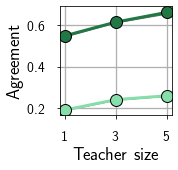

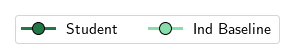

In [344]:
ax=make_plot(big_df, masks[0], "aug_train_matching", is_performance=False, with_teacher=False, with_baseline=True)
plt.ylabel("Agreement", fontsize=18)
plt.savefig("sec4_resnet20_agreement.pdf", bbox_inches="tight")

figlegend = plt.figure(figsize=(2,0.5))
plt.legend(*ax.get_legend_handles_labels(), 
           loc ='upper left',
           fontsize=16,
           ncol=2
          )
plt.axis("off")
plt.savefig("sec4_legend.pdf", bbox_inches="tight")
# plt.yticks([0.29, 0.3, 0.31], fontsize=14)

Number of trials: 9


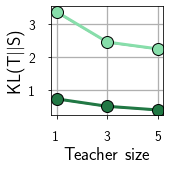

In [345]:
make_plot(big_df, masks[0], "aug_train_kl_ts", is_performance=False, with_teacher=False, with_baseline=True)
plt.ylabel(r"KL(T$\vert\vert$S)", fontsize=18)
plt.savefig("sec4_resnet20_kl.pdf", bbox_inches="tight")
# plt.yticks([0.29, 0.3, 0.31], fontsize=14)

Number of trials: 9


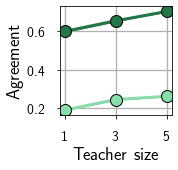

In [346]:
make_plot(big_df, masks[1], "aug_train_matching", is_performance=False, with_teacher=False, with_baseline=True)
plt.ylabel("Agreement", fontsize=18)
plt.savefig("sec4_resnet56_agreement.pdf", bbox_inches="tight")
# plt.yticks([0.29, 0.3, 0.31], fontsize=14)

Number of trials: 9


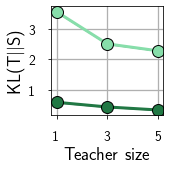

In [347]:
make_plot(big_df, masks[1], "aug_train_kl_ts", is_performance=False, with_teacher=False, with_baseline=True)
plt.ylabel(r"KL(T$\vert\vert$S)", fontsize=18)
plt.savefig("sec4_resnet56_kl.pdf", bbox_inches="tight")
# plt.yticks([0.29, 0.3, 0.31], fontsize=14)

## A/B experiments

### Metrics

In [308]:
big_df = pd.read_csv("subsample_df.csv")

masks = [
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "temperature": 4.,
        "distill_subsample_split": "Not specified",
        "subsample_split": 0,
        "loss_alpha": 0.
    }, {"color": color_2, "alpha": 1., "zorder": 0, "label": r"$D_0$"}),
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "temperature": 4.,
        "distill_subsample_split": "Not specified",
        "subsample_split": 1,
        "loss_alpha": 0.
    }, {"color": [183/255, 183/255, 200/255], "alpha": 1., "zorder": 1, "label": r"$D_1$"}),
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "distill_subsample_split": "[0, 1]",
        "distill_temp": "[4.0, 4.0]",
        "loss_alpha": 0.
    }, {"color": color_3, "alpha": 1., "zorder": 2, "label": r"$D_0 \cup D_1$"}),
]

In [309]:

def make_plot(df, masks, metric, with_teacher, is_performance=True):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    
    prefix = "student_" if is_performance else ""
    
    for mask_dict, mpl_params in masks:
        mask = functools.reduce(
            lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
            True)
        masked_results = big_df[mask]
        print("Number of trials:", len(masked_results))

        mean = masked_results.groupby("teacher_num_components").mean()[
                "{}{}".format(prefix,metric)]
        std = masked_results.groupby("teacher_num_components").std()[
                "{}{}".format(prefix,metric)]
        
        plt_mpl_params = {**mpl_params, "ms": 12, "mec": "k", "lw": 3}
        ax.plot(mean, "-o", **plt_mpl_params)
        
        fbtw_mpl_params = {**mpl_params, "alpha": 0.5}
        ax.fill_between(mean.index, mean+std, mean-std, **fbtw_mpl_params)
    
    if with_teacher:
        mean = masked_results.groupby("teacher_num_components").mean()[
                "teacher_{}".format(metric)]
        ax.plot(mean, "--ko", ms=10, mec="k", lw=3, label="Teacher")
    
    ax.set_xlabel("Teacher size", fontsize=18)
    ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
    ax.grid(True)
    return ax
        

In [310]:
ax = make_plot(big_df, masks, "aug_test_accuracy", with_teacher=True)
plt.title("Test Accuracy", fontsize=20)
plt.savefig("sec5_acc.pdf", bbox_inches="tight")
# plt.savefig("sec5_legend.pdf", bbox_inches="tight")
# plt.yticks([0.29, 0.3, 0.31], fontsize=14)

Number of trials: 9
Number of trials: 9
Number of trials: 9


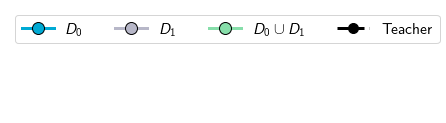

In [311]:
handles = ax.get_legend_handles_labels()
handles = (handles[0][:4], handles[1])
figlegend = plt.figure(figsize=(2,2))
plt.legend(*handles, 
           loc ='upper left',
           fontsize=16,
           ncol=4
          )
plt.axis("off")
plt.savefig("sec5_legend.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


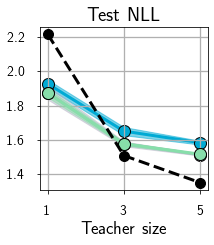

In [212]:
ax = make_plot(big_df, masks, "aug_test_nll", with_teacher=True)
plt.title("Test NLL", fontsize=20)
plt.savefig("sec5_nll.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


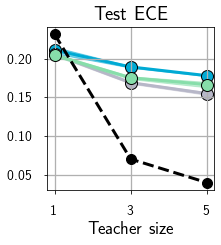

In [213]:
ax = make_plot(big_df, masks, "aug_test_ece", with_teacher=True)
plt.title("Test ECE", fontsize=20)
plt.savefig("sec5_ece.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


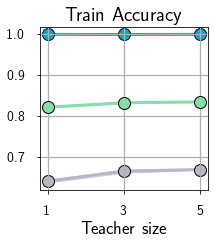

In [214]:
ax = make_plot(big_df, masks, "aug_train_accuracy", with_teacher=False)
plt.title("Train Accuracy", fontsize=20)
plt.savefig("sec5_train_acc.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


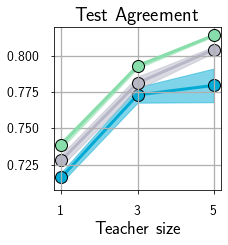

In [215]:
ax = make_plot(big_df, masks, "aug_test_matching", with_teacher=False, is_performance=False)
plt.title("Test Agreement", fontsize=20)
plt.savefig("sec5_agree.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


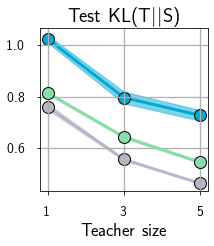

In [216]:
ax = make_plot(big_df, masks, "aug_test_kl_ts", with_teacher=False, is_performance=False)
plt.title(r"Test KL(T$\vert\vert$S)", fontsize=20)
plt.savefig("sec5_kl.pdf", bbox_inches="tight")

Number of trials: 9
Number of trials: 9
Number of trials: 9


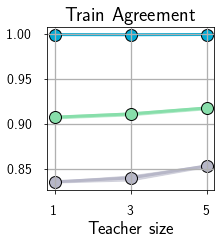

In [217]:
ax = make_plot(big_df, masks, "aug_train_matching", with_teacher=False, is_performance=False)
plt.title("Train Agreement", fontsize=20)
plt.savefig("sec5_train_agree.pdf", bbox_inches="tight")

### Temperature

In [325]:
big_df = pd.read_csv("subsample_df.csv")

big_df.loc[big_df["distill_temp"]=='[16.0, 16.0]', "temperature"] = 16.
big_df.loc[big_df["distill_temp"]=='[8.0, 8.0]', "temperature"] = 8.
big_df.loc[big_df["distill_temp"]=='[4.0, 4.0]', "temperature"] = 4.
big_df.loc[big_df["distill_temp"]=='[1.0, 1.0]', "temperature"] = 1.

big_df.loc[big_df["distill_temp"]=='[4.0, 0.25]', "temperature"] = -1.
big_df.loc[big_df["distill_temp"]=='[4.0, 1.0]', "temperature"] = -1.
big_df.loc[big_df["distill_temp"]=='[4.0, 0.5]', "temperature"] = -1.

masks = [
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "distill_subsample_split": "Not specified",
        "subsample_split": 0,
        "loss_alpha": 0.,
        "teacher_num_components": 5,
    }, {"color": color_2, "alpha": 1., "zorder": 0}),
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "distill_subsample_split": "Not specified",
        "subsample_split": 1,
        "loss_alpha": 0.,
        "teacher_num_components": 5,
    }, {"color": [183/255, 183/255, 200/255], "alpha": 1., "zorder": 1}),
    ({
        "teacher_depth": 56,
        "classifier_depth": 56,
        "distill_subsample_split": "[0, 1]",
        "loss_alpha": 0.,
        "teacher_num_components": 5,
    }, {"color": color_3, "alpha": 1., "zorder": 2}),
]

In [327]:
big_df = big_df[big_df["temperature"] >= 1.]

In [328]:
def make_plot(df, masks, metric, with_teacher, is_performance=True):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    
    prefix = "student_" if is_performance else ""
    
    for mask_dict, mpl_params in masks:
        mask = functools.reduce(
            lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
            True)
        masked_results = big_df[mask]
        print("Number of trials:", len(masked_results))

        mean = masked_results.groupby("temperature").mean()[
                "{}{}".format(prefix,metric)]
        std = masked_results.groupby("temperature").std()[
                "{}{}".format(prefix,metric)]
        
        plt_mpl_params = {**mpl_params, "ms": 12, "mec": "k", "lw": 3}
        ax.plot(mean, "-o", **plt_mpl_params)
        
        fbtw_mpl_params = {**mpl_params, "alpha": 0.5}
        ax.fill_between(mean.index, mean+std, mean-std, **fbtw_mpl_params)
    
    if with_teacher:
        mean = masked_results.groupby("teacher_num_components").mean()[
                "teacher_{}".format(metric)]
        ax.hlines(mean, -1, 20, "k", linestyle="dashed", lw=3)
    
    ax.set_xlabel("Temperature", fontsize=18)
    ax.set_xticks([1, 4, 8, 16])
    ax.set_xlim(-0., 17.)
#     ax.set_xticklabels(fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
    ax.grid(True)
    return ax

Number of trials: 11
Number of trials: 11
Number of trials: 12


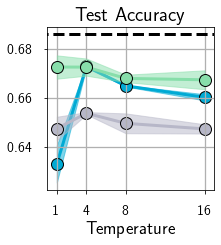

In [329]:
ax = make_plot(big_df, masks, "aug_test_accuracy", with_teacher=True)
plt.title("Test Accuracy", fontsize=20)
plt.savefig("sec5_temp_acc.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


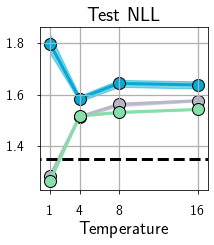

In [330]:
ax = make_plot(big_df, masks, "aug_test_nll", with_teacher=True)
plt.title("Test NLL", fontsize=20)
plt.savefig("sec5_temp_nll.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


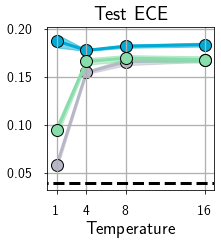

In [331]:
ax = make_plot(big_df, masks, "aug_test_ece", with_teacher=True)
plt.title("Test ECE", fontsize=20)
plt.savefig("sec5_temp_ece.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


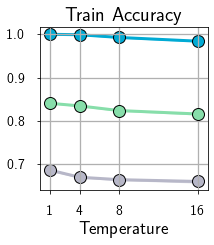

In [332]:
ax = make_plot(big_df, masks, "aug_train_accuracy", with_teacher=False)
plt.title("Train Accuracy", fontsize=20)
plt.savefig("sec5_temp_train_acc.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


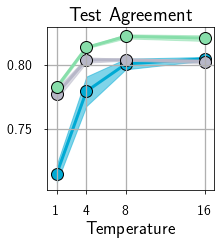

In [333]:
ax = make_plot(big_df, masks, "aug_test_matching", with_teacher=False, is_performance=False)
plt.title("Test Agreement", fontsize=20)
plt.savefig("sec5_temp_agree.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


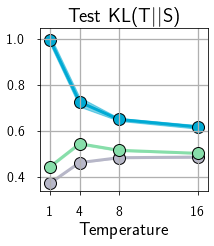

In [334]:
ax = make_plot(big_df, masks, "aug_test_kl_ts", with_teacher=False, is_performance=False)
plt.title(r"Test KL(T$\vert\vert$S)", fontsize=20)
plt.savefig("sec5_temp_kl.pdf", bbox_inches="tight")

Number of trials: 11
Number of trials: 11
Number of trials: 12


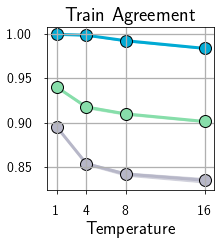

In [335]:
ax = make_plot(big_df, masks, "aug_train_matching", with_teacher=False, is_performance=False)
plt.title("Train Agreement", fontsize=20)
plt.savefig("sec5_temp_train_agree.pdf", bbox_inches="tight")

## Intro Figure

In [118]:
arr = np.load("num_synth_ablation.npz")

In [119]:
list(arr.keys())

['num_synth',
 'test_ts_agree_mean',
 'test_ts_agree_lb',
 'test_ts_agree_ub',
 'test_acc_mean',
 'test_acc_lb',
 'test_acc_ub',
 'teacher_test_acc_mean']

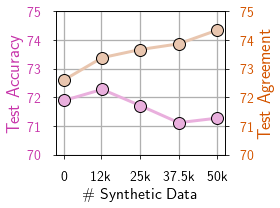

In [117]:
fig, ax1 = plt.subplots(figsize=(4, 3))

color = [233/255, 175/255, 221/255]#[183/255, 183/255, 200/255]#color_1
text_color = [200/255, 55/255, 171/255]#color_1

ax1.set_xlabel('\# Synthetic Data', fontsize=16)
ax1.set_ylabel('Test Accuracy', color=text_color, fontsize=18)
ax1.plot(arr["num_synth"], arr["test_acc_mean"], "-o", 
         color=color, lw=3, ms=12, markeredgewidth=1., markeredgecolor="k")
ax1.tick_params(axis='y', labelcolor=text_color)

# ax1.set_yticks(corruptions, ['0', '5k', '10k', '20k', '30k', '40k', '50k'])
# ax2.set_xticks([0, 12e3, 25e3, 37.5e3, 50e3], ['0', '12k', '25k', '37.5k', '50k'])
ax1.set_xticks([0, 12e3, 25e3, 37.5e3, 50e3])
ax1.set_xticklabels(['0', '12k', '25k', '37.5k', '50k'])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_xticks([0, 12e3, 25e3, 37.5e3, 50e3], ['0', '12k', '25k', '37.5k', '50k'])

color = [233/255, 198/255, 175/255]#[183/255, 183/255, 200/255]#color_1
text_color = [212/255, 85/255, 0/255]#color_1

ax2.set_ylabel('Test Agreement', color=text_color, fontsize=18)  # we already handled the x-label with ax1
ax2.plot(arr["num_synth"], arr["test_ts_agree_mean"], "-o", color=color, lw=3, ms=12, markeredgewidth=1., markeredgecolor="k")
ax2.tick_params(axis='y', labelcolor=text_color)
# ax2.set_xticks(arr["num_synth"])
ax2.set_yticks([70, 71, 72, 73, 74, 75])#[72, 73, 74, 75])
ax1.set_yticks([70, 71, 72, 73, 74, 75])


ax2.tick_params(axis='y', which='major', labelsize=14)
ax2.tick_params(axis='x', which='major', labelsize=14)
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.tick_params(axis='x', which='major', labelsize=14)
# ax2.grid(False)
ax1.grid(True, axis="both")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("intro_fig1.pdf", bbox_inches="tight")
# # plt.show()

In [118]:
big_df = pd.read_csv("results_combined_v2.csv")


masks = OrderedDict()
masks = [{
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 4.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"},
    {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]"}
]


Number of trials: 9
Number of trials: 9


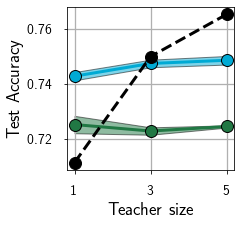

In [119]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)

# T = 4
mask = functools.reduce(
    lambda a, b: a & b, [big_df[key] == value for key, value in masks[0].items()],
    True)
masked_results = big_df[mask]
print("Number of trials:", len(masked_results))

mean = masked_results.groupby("teacher_num_components").mean()
std = masked_results.groupby("teacher_num_components").std()

ax.plot(mean["student_test_accuracy"], 
        "-o", ms=12, mec="k", lw=3, color=color_2, label="Student (T=4)")
ax.fill_between(mean.index, (mean+std)["student_test_accuracy"], 
                (mean-std)["student_test_accuracy"], color=color_2, alpha=0.5, ec="k")

# T = 1
mask = functools.reduce(
    lambda a, b: a & b, [big_df[key] == value for key, value in masks[1].items()],
    True)
masked_results = big_df[mask]
print("Number of trials:", len(masked_results))

mean = masked_results.groupby("teacher_num_components").mean()
std = masked_results.groupby("teacher_num_components").std()

ax.plot(mean["student_test_accuracy"], 
        "-o", ms=12, mec="k", lw=3, color=color_1, label="Student")
ax.fill_between(mean.index, (mean+std)["student_test_accuracy"], 
                (mean-std)["student_test_accuracy"], color=color_1, alpha=0.5, ec="k")
ax.plot(mean["teacher_test_accuracy"], "--ko", ms=12, mec="k", lw=3, label="Teacher")


ax.set_xlabel("Teacher size", fontsize=18)
ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
ax.grid(True)

plt.ylabel("Test Accuracy", fontsize=18)
# plt.legend(fontsize=16)
plt.savefig("intro_accuracy.pdf", bbox_inches="tight")

In [120]:
handles = ax.get_legend_handles_labels()

Number of trials: 9


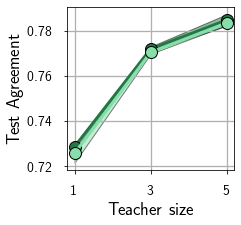

In [121]:

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)

mask = functools.reduce(
    lambda a, b: a & b, [big_df[key] == value for key, value in masks[1].items()],
    True)
masked_results = big_df[mask]
print("Number of trials:", len(masked_results))

mean = masked_results.groupby("teacher_num_components").mean()
std = masked_results.groupby("teacher_num_components").std()

ax.plot(mean["test_matching"], 
        "-o", ms=12, mec="k", lw=3, color=color_1, label="Student")
ax.fill_between(mean.index, (mean+std)["test_matching"], 
                (mean-std)["test_matching"], color=color_1, alpha=0.5, ec="k")

ax.plot(mean["baseline_test_matching"], 
        "-o", ms=12, mec="k", lw=3, color=color_3, label="Ind Baseline")
ax.fill_between(mean.index, (mean+std)["baseline_test_matching"], 
                (mean-std)["baseline_test_matching"], color=color_3, alpha=0.5, ec="k")


ax.set_xlabel("Teacher size", fontsize=18)
ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
ax.grid(True)
plt.ylabel("Test Agreement", fontsize=18)
# plt.legend(fontsize=16)
plt.savefig("intro_agreement.pdf", bbox_inches="tight")

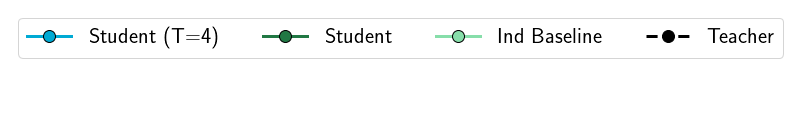

In [126]:
# handles += ax.get_legend_handles_labels()
# handles = (handles[0] + [ax.get_legend_handles_labels()[0][1]],
#            handles[1] + [ax.get_legend_handles_labels()[1][1]])

# handles = [handles[0][i] for i in [0,1,3,2]], [handles[1][i] for i in [0,1,3,2]]
figlegend = plt.figure(figsize=(2,2))
plt.legend(*handles, 
           loc ='upper left',
           fontsize=22,
           ncol=4
          )
plt.axis("off")
plt.savefig("intro_legend.pdf", bbox_inches="tight")

In [91]:
handles

([<matplotlib.lines.Line2D at 0x7fb669989250>,
 ['Student', 'Student', 'Teacher', 'Ind Baseline'])

## HeatMaps Sec 5

In [387]:
from matplotlib import colors

In [447]:
xs = np.arange(0, 100, 10)
cmap_colors = [cmo.cm.deep(x) for x in xs]#[::-1]
my_cmap = colors.ListedColormap(cmap_colors)

<ipython-input-448-a261c487737b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 1, 3, 5], fontsize=14)


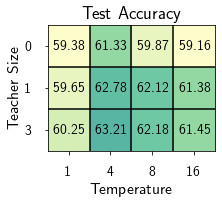

In [448]:
df = pd.read_pickle("resnet20_test_acc_heatmap_df.pkl")

temps = [1., 4., 8., 16]
teachers = np.array([1, 3, 5])
accs = np.array(df)

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(accs.T, cmap=my_cmap)
ax.set_yticklabels([0, 1, 3, 5], fontsize=14)
ax.set_xticks([0., 1., 2., 3.])
ax.set_yticks([0., 1., 2.])
ax.set_xticklabels([1, 4, 8, 16], fontsize=14)
ax.set_ylabel("Teacher Size", fontsize=16)
ax.set_xlabel("Temperature", fontsize=16)

for j in range(4):
    for i in range(3):
        ax.text(j, i, r"{:.2f}".format(accs.T[i, j]), 
                 fontsize=14, ha='center', va='center')
for i in range(2):
    ax.plot([-0.5, 3.5], [i+0.5, i+0.5], "-k")
for j in range(3):
    ax.plot([j+0.5, j+0.5], [-0.5, 2.5], "-k")
    
ax.set_title("Test Accuracy", fontsize=18)
plt.savefig("sec5_acc_heat.pdf")
# for j in range(3):
#     plt.plot([n, n], [0, len(y)], "--k")

<ipython-input-449-5b1aa252b8ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 1, 3, 5], fontsize=14)


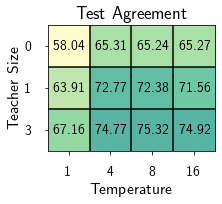

In [449]:
df = pd.read_pickle("resnet20_test_agree_heatmap_df.pkl")

temps = [1., 4., 8., 16]
teachers = np.array([1, 3, 5])
accs = np.array(df)

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(accs.T, cmap=my_cmap)
ax.set_yticklabels([0, 1, 3, 5], fontsize=14)
ax.set_xticks([0., 1., 2., 3.])
ax.set_yticks([0., 1., 2.])
ax.set_xticklabels([1, 4, 8, 16], fontsize=14)
ax.set_ylabel("Teacher Size", fontsize=16)
ax.set_xlabel("Temperature", fontsize=16)

for j in range(4):
    for i in range(3):
        ax.text(j, i, r"{:.2f}".format(accs.T[i, j]), 
                 fontsize=14, ha='center', va='center')
for i in range(2):
    ax.plot([-0.5, 3.5], [i+0.5, i+0.5], "-k")
for j in range(3):
    ax.plot([j+0.5, j+0.5], [-0.5, 2.5], "-k")
    
ax.set_title("Test Agreement", fontsize=18)
plt.savefig("sec5_agree_heat.pdf")
# for j in range(3):
#     plt.plot([n, n], [0, len(y)], "--k")

## MNIST Num Data Plot

In [5]:
def mask_from_dict(mask_dict):
    return functools.reduce(
        lambda a, b: a & b, 
        [big_df[key] == value for key, value in mask_dict.items()], True)

In [6]:
big_df = pd.read_csv("results_combined_mnist.csv")

masks = [
    {
        "dataset": "mnist",
        "teacher_num_components": 1
    },
    {
        "dataset": "emnist",
        "teacher_num_components": 1,
        "subsample_ratio": 0.25,
    },
    {
        "dataset": "emnist",
        "teacher_num_components": 1,
        "subsample_ratio": 0.5,
    },
    {
        "dataset": "emnist",
        "teacher_num_components": 1,
        "subsample_ratio": 1.,
    },
]

In [7]:
def get_mean_std(masks, metric):
    means = [big_df[mask_from_dict(mask)][metric].mean() for mask in masks]
    stds = [big_df[mask_from_dict(mask)][metric].std() for mask in masks]
    return np.array(means), np.array(stds)

acc_mean, acc_std = get_mean_std(masks, "student_test_accuracy")
agg_mean, agg_std = get_mean_std(masks, "test_matching")
kl_mean, kl_std = get_mean_std(masks, "test_kl_ts")
b_agg_mean, b_agg_std = get_mean_std(masks, "baseline_test_matching")

In [8]:
b_agg_mean

array([0.8277    , 0.84103333, 0.84128333, 0.84081667])

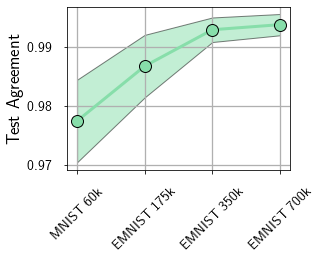

In [43]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

xs = np.arange(len(agg_mean))

ax.plot(agg_mean, 
        "-o", ms=12, mec="k", lw=3, color=color_3, label="Student")
ax.fill_between(xs, (agg_mean+agg_std), 
                (agg_mean-agg_std), color=color_3, alpha=0.5, ec="k")


# ax.set_xlabel("Teacher size", fontsize=18)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["MNIST 60k", r"EMNIST 175k", r"EMNIST 350k", r"EMNIST 700k"],fontsize=14, rotation=45)
ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
ax.grid(True)
plt.ylabel("Test Agreement", fontsize=18)
# plt.legend(fontsize=16)
plt.savefig("mnist_agreement.pdf", bbox_inches="tight")

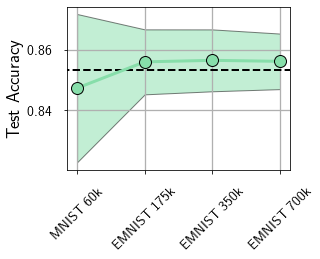

In [60]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

xs = np.arange(len(agg_mean))

ax.plot(acc_mean, 
        "-o", ms=12, mec="k", lw=3, color=color_3, label="Student")
ax.fill_between(xs, (acc_mean+acc_std), 
                (acc_mean-acc_std), color=color_3, alpha=0.5, ec="k")


# ax.set_xlabel("Teacher size", fontsize=18)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["MNIST 60k", r"EMNIST 175k", r"EMNIST 350k", r"EMNIST 700k"],fontsize=14, rotation=45)
ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
ax.grid(True)
ax.hlines(0.8534, -1, 5, "k", linestyle="dashed", lw=2)
plt.ylabel("Test Accuracy", fontsize=18)
ax.set_xlim(-0.15, 3.15)
# plt.legend(fontsize=16)
plt.savefig("mnist_acc.pdf", bbox_inches="tight")

In [12]:
(big_df[big_df["teacher_num_components"]==1]["teacher_test_accuracy"]).mean()

0.8534583333333333

In [10]:
big_df[big_df["teacher_num_components"]==1]

Unnamed: 0  index  trial_id  teacher_train_accuracy  teacher_train_nll  \
0            0      0         1                0.801500           1.669988   
1            1      1         3                0.842017           1.464764   
2            2      2         2                0.852583           1.247543   
9            9      0         1                0.852583           1.247543   
10          10      1         3                0.852967                inf   
11          11      2         2                0.834917           1.447108   
12          12      3         1                0.852583           1.247543   
13          13      4         3                0.852967                inf   
14          14      5         2                0.834917           1.447108   
15          15      6         1                0.852583           1.247543   
16          16      7         3                0.852967                inf   
17          17      8         2                0.834917           1.447108   

    teacher_train_ece  teacher_test_accuracy  teacher_test_nll  \
0            0.143840                 0.8208          1.465464   
1            0.116217                 0.8530          1.386188   
2            0.107310                 0.8628          1.176679   
9            0.107310                 0.8628          1.176679   
10           0.098969                 0.8607          1.740861   
11           0.121578                 0.8448          1.364641   
12           0.107310                 0.8628          1.176679   
13           0.098969                 0.8607          1.740861   
14           0.121578                 0.8448          1.364641   
15           0.107310                 0.8628          1.176679   
16           0.098969                 0.8607          1.740861   
17           0.121578                 0.8448          1.364641   

    teacher_test_ece  student_train_accuracy  ...  baseline_test_kl_st  \
0           0.129503                0.801317  ...                  NaN   
1           0.106785                0.841917  ...                  NaN   
2           0.098716                0.852550  ...                  NaN   
9           0.098716                0.854067  ...                  NaN   
10          0.097651                0.850350  ...                  NaN   
11          0.115665                0.834633  ...                  NaN   
12          0.098716                0.853150  ...                  NaN   
13          0.097651                0.851933  ...                  NaN   
14          0.115665                0.834250  ...                  NaN   
15          0.098716                0.852333  ...                  NaN   
16          0.097651                0.851500  ...                  NaN   
17          0.115665                0.834617  ...                  NaN   

    baseline_test_sym_kl  baseline_test_matching  teacher_num_components  \
0                    NaN                 0.81915                       1   
1                    NaN                 0.83365                       1   
2                    NaN                 0.83030                       1   
9                    NaN                 0.84400                       1   
10                   NaN                 0.84100                       1   
11                   NaN                 0.83810                       1   
12                   NaN                 0.84570                       1   
13                   NaN                 0.84035                       1   
14                   NaN                 0.83780                       1   
15                   NaN                 0.84540                       1   
16                   NaN                 0.83990                       1   
17                   NaN                 0.83715                       1   

    dataset  subsample_split  subsample_seed  subsample_ratio  loss_alpha  \
0     mnist                0               0             1.00         0.0   
1     mnist             

## Performance vs Teacher size

In [283]:
arr = np.load("ensemble_size_ablation_test_acc.npz")
student_std = (arr["test_acc_ub"] - arr["test_acc_mean"]) / 3
student_std = (arr["teacher_test_acc_ub"] - arr["teacher_test_acc_mean"]) / 3

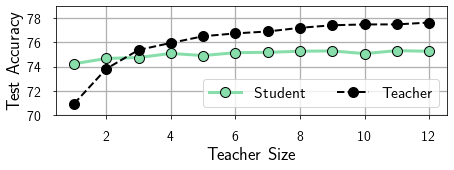

In [288]:
f = plt.figure(figsize=(7, 2))

# color = [233/255, 175/255, 221/255]#[183/255, 183/255, 200/255]#color_1
# text_color = [200/255, 55/255, 171/255]#color_1



plt.xlabel('Teacher Size', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=18)
# plt.plot(arr["num_teachers"], arr["test_acc_mean"] + student_std, "-", 
#          color=color_3, lw=2)
# plt.plot(arr["num_teachers"], arr["test_acc_mean"] - student_std, "-", 
#          color=color_3, lw=2)
# plt.fill_between(arr["num_teachers"], 
#                  arr["test_acc_mean"] + student_std,
#                  arr["test_acc_mean"] - student_std,
#                  color=color_3, alpha=0.3)

plt.plot(arr["num_teachers"], arr["test_acc_mean"], "-o", 
         color=color_3, lw=3, ms=10, markeredgewidth=1., markeredgecolor="k", label="Student")

plt.plot(arr["num_teachers"], arr["teacher_test_acc_mean"], "--ko", lw=2, ms=10, label="Teacher")
plt.legend(fontsize=16, ncol=2)



plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(70, 79)

plt.savefig("baseline_manyteachers.pdf", bbox_inches="tight")

In [278]:
arr = np.load("ensemble_size_ablation.npz")
# student_std = (arr["test_acc_ub"] - arr["test_acc_mean"]) / 3
# student_std = (arr["teacher_test_acc_ub"] - arr["teacher_test_acc_mean"]) / 3

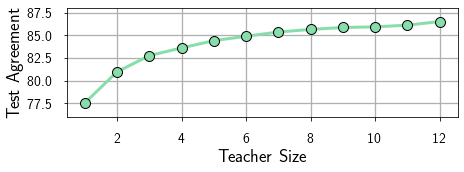

In [282]:
f = plt.figure(figsize=(7, 2))

# color = [233/255, 175/255, 221/255]#[183/255, 183/255, 200/255]#color_1
# text_color = [200/255, 55/255, 171/255]#color_1



plt.xlabel('Teacher Size', fontsize=18)
plt.ylabel('Test Agreement', fontsize=18)
# plt.plot(arr["num_teachers"], arr["test_acc_mean"] + student_std, "-", 
#          color=color_3, lw=2)
# plt.plot(arr["num_teachers"], arr["test_acc_mean"] - student_std, "-", 
#          color=color_3, lw=2)
# plt.fill_between(arr["num_teachers"], 
#                  arr["test_acc_mean"] + student_std,
#                  arr["test_acc_mean"] - student_std,
#                  color=color_3, alpha=0.3)

plt.plot(arr["num_teachers"], arr["test_ts_agree_mean"], "-o", 
         color=color_3, lw=3, ms=10, markeredgewidth=1., markeredgecolor="k", label="Student")



plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(76, 88)

plt.savefig("baseline_manyteachers_agree.pdf", bbox_inches="tight")

## CIFAR Prediction Histograms

In [92]:

r20_path = "../../../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_5-preresnet20_1/trial_{}/2021-01-24_10-59-18/teacher_probs.npz"
r56_path = "../../../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_5-preresnet56_1/trial_{}/2021-01-24_10-59-18/teacher_probs.npz"
r110_path = "../../../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet110_5-preresnet110_1/trial_{}/2021-01-24_10-59-18/teacher_probs.npz"
all_preds = {}

for depth, path in [(20, r20_path), (56, r56_path), (110, r110_path)]:
    for trial in [1]:
        all_preds["r{}_nteach5_trial{}".format(depth, trial)] = np.load(path.format(trial))

In [177]:
def make_hist(depth, nteachers, img_id, train=True):
    plt.figure(figsize=(5,3))
    xs = np.arange(100)
    key = "train_probs" if train else "test_probs"
    ys = all_preds["r{}_nteach5_trial1".format(depth)][key][img_id, :nteachers].mean(axis=0)
    ys_t4 = np.exp(np.log(ys) / 4)
    ys_t4 /= ys_t4.sum()
    
    
    if train:
        plt.bar(xs, ys, width=4., alpha=0.9, color=color_2, edgecolor="k", zorder=2)
        plt.bar(xs, ys_t4, width=4., alpha=0.7, color=color_3, edgecolor="k", zorder=2)
    else:
        plt.bar(xs, ys, width=4., alpha=0.9, color=[233/255, 175/255, 221/255], edgecolor="k", zorder=2)
    plt.grid()
    name = "ResNet-{}".format(depth)
    if nteachers > 1:
        name = r"${} \times$".format(nteachers) + name
    plt.title(name, fontsize=26)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # plt.ylim(0, 1)
    plt.xlim(-0.5, 101.5)
    plt.xlabel("Class id", fontsize=22)
    plt.ylabel("Class Probability", fontsize=22)

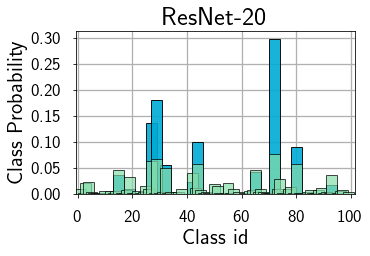

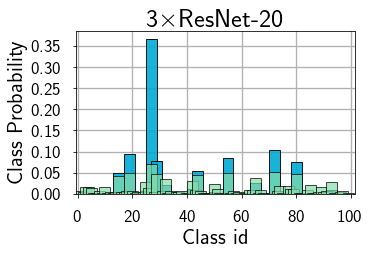

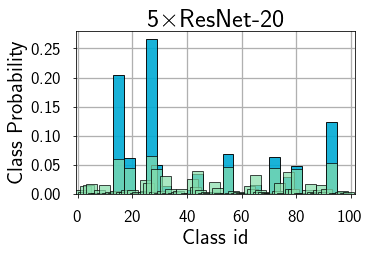

In [178]:
confs = all_preds["r20_nteach5_trial1"]['train_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 2]
train_id = conf_ids[len(confs) // 100+9]

make_hist(20, 1, train_id)
plt.savefig("1r20_train_hist.pdf", bbox_inches="tight")
make_hist(20, 3, train_id)
plt.savefig("3r20_train_hist.pdf", bbox_inches="tight")
make_hist(20, 5, train_id)
plt.savefig("5r20_train_hist.pdf", bbox_inches="tight")

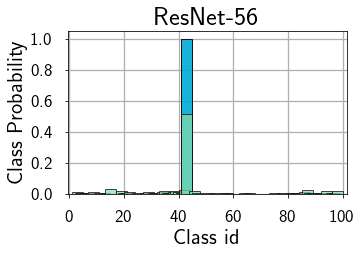

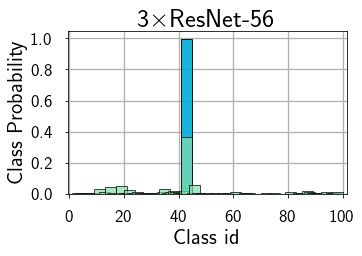

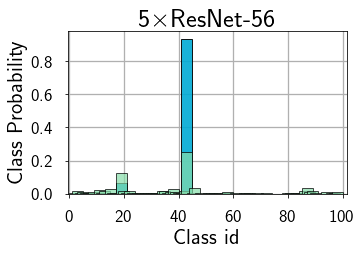

In [179]:
confs = all_preds["r56_nteach5_trial1"]['train_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 1]
train_id = conf_ids[len(confs) // 100+1]

make_hist(56, 1, train_id)
plt.savefig("1r56_train_hist.pdf", bbox_inches="tight")
make_hist(56, 3, train_id)
plt.savefig("3r56_train_hist.pdf", bbox_inches="tight")
make_hist(56, 5, train_id)
plt.savefig("5r56_train_hist.pdf", bbox_inches="tight")

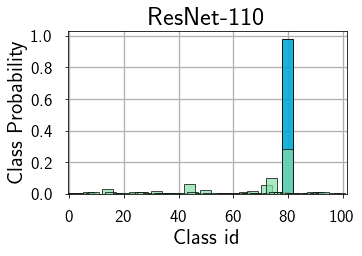

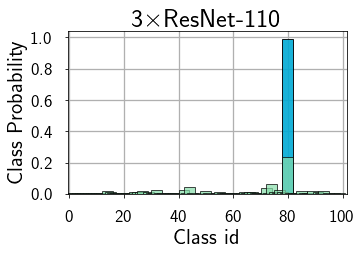

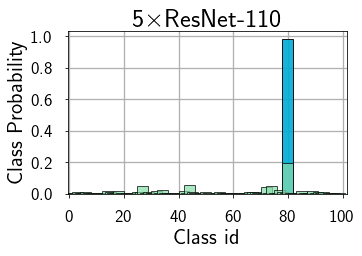

In [180]:
confs = all_preds["r110_nteach5_trial1"]['train_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 1]
train_id = conf_ids[len(confs) // 100]

make_hist(110, 1, train_id)
plt.savefig("1r110_train_hist.pdf", bbox_inches="tight")
make_hist(110, 3, train_id)
plt.savefig("3r110_train_hist.pdf", bbox_inches="tight")
make_hist(110, 5, train_id)
plt.savefig("5r110_train_hist.pdf", bbox_inches="tight")

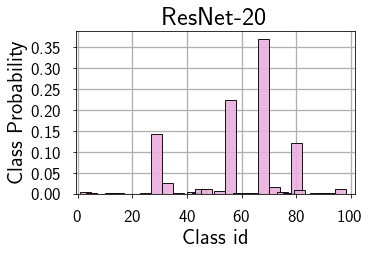

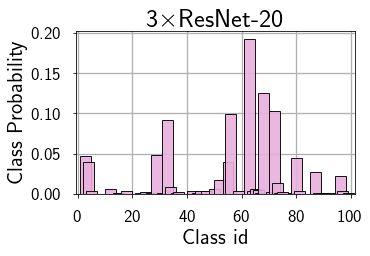

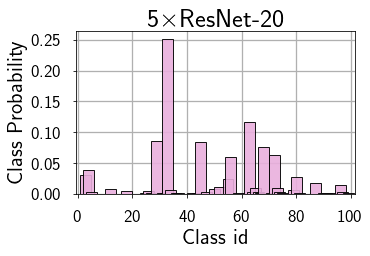

In [181]:
confs = all_preds["r20_nteach5_trial1"]['test_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 1]
train_id = conf_ids[len(confs) // 100+1]

make_hist(20, 1, train_id, train=False)
plt.savefig("1r20_test_hist.pdf", bbox_inches="tight")
make_hist(20, 3, train_id, train=False)
plt.savefig("3r20_test_hist.pdf", bbox_inches="tight")
make_hist(20, 5, train_id, train=False)
plt.savefig("5r20_test_hist.pdf", bbox_inches="tight")

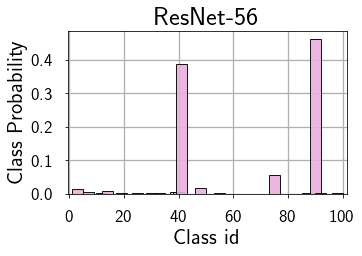

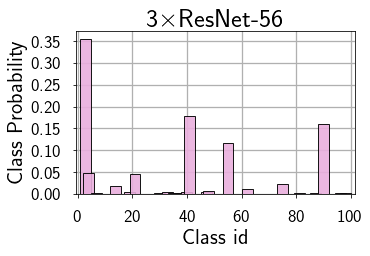

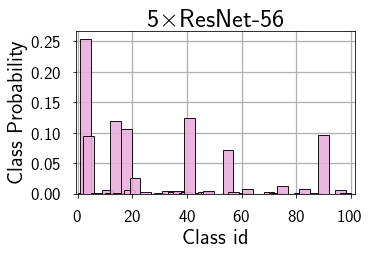

In [182]:
confs = all_preds["r56_nteach5_trial1"]['test_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 1]
train_id = conf_ids[len(confs) // 100+4]

make_hist(56, 1, train_id, train=False)
plt.savefig("1r56_test_hist.pdf", bbox_inches="tight")
make_hist(56, 3, train_id, train=False)
plt.savefig("3r56_test_hist.pdf", bbox_inches="tight")
make_hist(56, 5, train_id, train=False)
plt.savefig("5r56_test_hist.pdf", bbox_inches="tight")

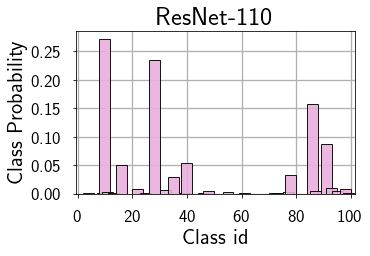

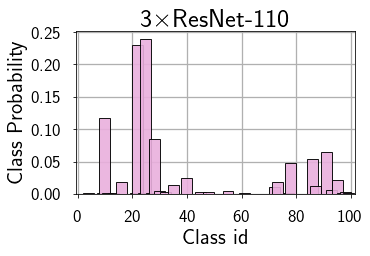

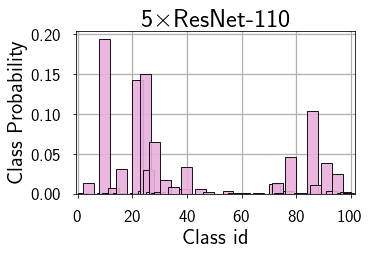

In [183]:
confs = all_preds["r110_nteach5_trial1"]['test_probs'].max(axis=2).mean(axis=1)
conf_ids = np.argsort(confs)
# train_id = conf_ids[len(confs) // 10 + 1]
train_id = conf_ids[len(confs) // 100+4]

make_hist(110, 1, train_id, train=False)
plt.savefig("1r110_test_hist.pdf", bbox_inches="tight")
make_hist(110, 3, train_id, train=False)
plt.savefig("3r110_test_hist.pdf", bbox_inches="tight")
make_hist(110, 5, train_id, train=False)
plt.savefig("5r110_test_hist.pdf", bbox_inches="tight")

## $\alpha$ ablation

In [289]:
# color = [233/255, 175/255, 221/255]#[183/255, 183/255, 200/255]#color_1
# text_color = [200/255, 55/255, 171/255]#color_1
# plt.fill_between(arr["num_teachers"], 
#                  arr["test_acc_mean"] + student_std,
#                  arr["test_acc_mean"] - student_std,
#                  color=color_3, alpha=0.3)



def make_alpha_plot(arr, acc=True):
    
    acc_mean = arr['test_acc_mean']
    acc_std = (arr['test_acc_ub'] - acc_mean) / 3
    teacher_acc_mean = arr['teacher_test_acc_mean']
    agree_mean = arr['test_agree_mean']
    agree_std = (arr['test_agree_ub'] - agree_mean) / 3
    
    f = plt.figure(figsize=(3, 2.5))
    plt.xlabel(r'$\alpha$', fontsize=18)
    if acc:
        plt.ylabel('Test Accuracy', fontsize=18)
        plt.plot(arr["alpha"], acc_mean, "-o", 
             color=color_3, lw=3, ms=10, markeredgewidth=1., markeredgecolor="k", label="Student")

        plt.hlines(teacher_acc_mean, 0., 0.7, color="k", linestyle="dashed", lw=2, label="Teacher")
    else:
        plt.ylabel('Test Agreement', fontsize=18)
        plt.plot(arr["alpha"], agree_mean, "-o", 
             color=color_3, lw=3, ms=10, markeredgewidth=1., markeredgecolor="k", label="Student")
#     plt.legend(fontsize=16)


    plt.grid()
    plt.xticks(arr["alpha"], 
               [str(int(alpha)) if alpha==int(alpha) else str(alpha) for alpha in arr["alpha"]],
               fontsize=14)
    plt.yticks(fontsize=14)

# plt.savefig("alpha_ablation_resnet56_1.pdf", bbox_inches="tight")

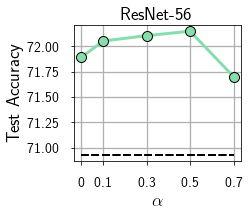

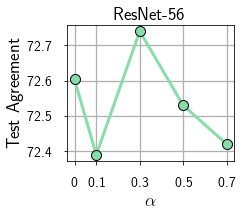

In [290]:
arr_nt1 = np.load("alpha_ablation_resnet56_1_temp_1.0.npz")
make_alpha_plot(arr_nt1, acc=True)
plt.title("ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_1_acc.pdf", bbox_inches="tight")
make_alpha_plot(arr_nt1, acc=False)
plt.title("ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_1_agree.pdf", bbox_inches="tight")

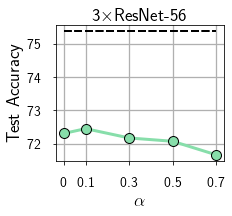

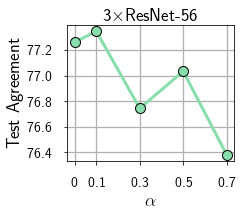

In [291]:
arr_nt1 = np.load("alpha_ablation_resnet56_3_temp_1.0.npz")
make_alpha_plot(arr_nt1, acc=True)
plt.title(r"$3\times$ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_3_acc.pdf", bbox_inches="tight")
make_alpha_plot(arr_nt1, acc=False)
plt.title(r"$3\times$ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_3_agree.pdf", bbox_inches="tight")

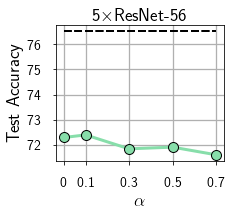

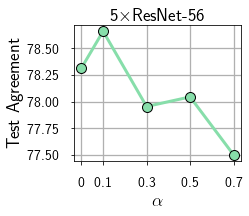

In [292]:
arr_nt1 = np.load("alpha_ablation_resnet56_5_temp_1.0.npz")
make_alpha_plot(arr_nt1, acc=True)
plt.title(r"$5\times$ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_5_acc.pdf", bbox_inches="tight")
make_alpha_plot(arr_nt1, acc=False)
plt.title(r"$5\times$ResNet-56", fontsize=18)
plt.savefig("alpha_ablation_resnet56_5_agree.pdf", bbox_inches="tight")

## Student Capacity Ablation

In [232]:
big_df = pd.read_csv("results_combined_v3.csv")


masks = OrderedDict()
masks[r"ResNet-20$\rightarrow$ResNet-56"] = {
        "teacher_depth": 20,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]",
        "gan_ratio": "Not Specified"
    }

masks[r"ResNet-20$\rightarrow$ResNet-20"] = {
        "teacher_depth": 20,
        "classifier_depth": 20,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]",
        "gan_ratio": "Not Specified"
    }

masks[r"ResNet-56$\rightarrow$ResNet-56"] = {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]",
        "gan_ratio": "Not Specified"
    }

masks[r"ResNet-56$\rightarrow$ResNet-110"] = {
        "teacher_depth": 56,
        "classifier_depth": 110,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
        "dataset": "cifar100",
        "tensor_augmentations": "[]",
        "gan_ratio": "Not Specified"
    }


In [233]:
metrics = OrderedDict()
metrics["Accuracy"] = "student_test_accuracy"
metrics["NLL"] = "student_test_nll"
metrics["ECE"] = "student_test_ece"
metrics["Agreement"] = "test_matching"
metrics["Baseline Agreement"] = "baseline_test_matching"
metrics[r"$KL(T \vert\vert S)$"] = "test_kl_ts"
metrics[r"Baseline $KL(T \vert\vert S)$"] = "baseline_test_kl_ts"

df = []
for j, (exp_name, mask_dict) in enumerate(masks.items()):
#     mask_dict.update({"teacher_num_components": 5})
    mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
        True)
    masked_results = big_df[mask]
    print("Number of trials:", len(masked_results))
    mean = masked_results.groupby("teacher_num_components").mean().reset_index()
    mean["name"] = exp_name
    if j == 0:
        df = mean[["name", "teacher_num_components", "teacher_test_accuracy", "teacher_test_nll", "teacher_test_ece", *metrics.values()]]
    else:
        df = df.append(mean[["name", "teacher_num_components", "teacher_test_accuracy", "teacher_test_nll", "teacher_test_ece", *metrics.values()]])
df = df.reset_index()

Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9


In [234]:
df[["name", "student_test_accuracy"]]

name  student_test_accuracy
0    ResNet-20$\rightarrow$ResNet-56               0.731967
1    ResNet-20$\rightarrow$ResNet-56               0.740333
2    ResNet-20$\rightarrow$ResNet-56               0.743567
3    ResNet-20$\rightarrow$ResNet-20               0.683700
4    ResNet-20$\rightarrow$ResNet-20               0.691800
5    ResNet-20$\rightarrow$ResNet-20               0.695433
6    ResNet-56$\rightarrow$ResNet-56               0.725333
7    ResNet-56$\rightarrow$ResNet-56               0.722967
8    ResNet-56$\rightarrow$ResNet-56               0.724633
9   ResNet-56$\rightarrow$ResNet-110               0.746933
10  ResNet-56$\rightarrow$ResNet-110               0.747667
11  ResNet-56$\rightarrow$ResNet-110               0.748833

In [235]:
def make_plot(df, metric, 
              is_performance, with_teacher, with_baseline,
              student_color=color_1, teacher_color=color_2, baseline_color=color_3):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    
    
    if is_performance:
        model_color_list = [["student", "-o", student_color, "Student"]]
        if with_teacher:
            model_color_list.append(["teacher", "--o", "k", "Teacher"])
        for model, line, color, label in model_color_list:

            ax.plot([1, 3, 5], df["{}_{}".format(model, metric)], line, 
                    ms=15, mec="k", lw=4, color=color, label=label)
    else:
        model_color_list = [["", student_color, "Student"]]
        if with_baseline:
            model_color_list.append(["baseline_", baseline_color, "Ind Baseline"])
        for model, color, label in model_color_list:
            actual_metric = "{}{}".format(model, metric)
            ax.plot([1, 3, 5], df[actual_metric], "-o", ms=15, mec="k",
                     lw=4, color=color, label=label)
    
    ax.set_xlabel("Teacher size", fontsize=18)
    ax.set_xticks([1, 3, 5])
#     ax.set_xticklabels(fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
#     ax.set_yticks(fontsize=14)
    ax.grid(True)
    return ax
        

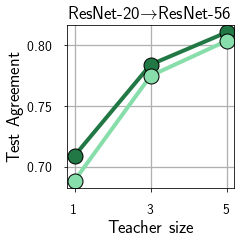

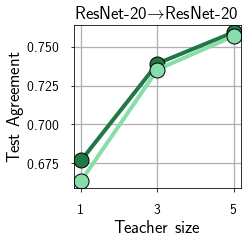

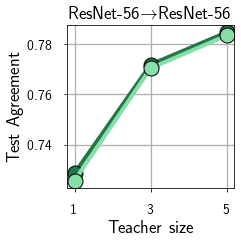

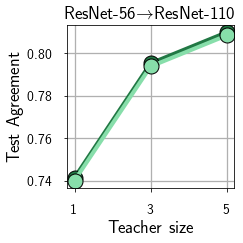

In [265]:
for name in df["name"].unique():
    ax = make_plot(df[df["name"]==name], "test_matching", is_performance=False, with_teacher=False, with_baseline=True)
    ax.set_ylabel("Test Agreement", fontsize=18)
    ax.set_title(name, fontsize=18)
    plt.savefig("supp_{}_agreement.pdf".format(name.replace("$\\rightarrow$", "-")), bbox_inches="tight")

handles1 = ax.get_legend_handles_labels()

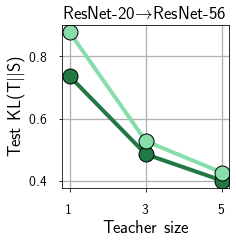

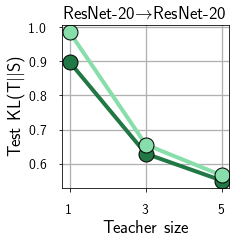

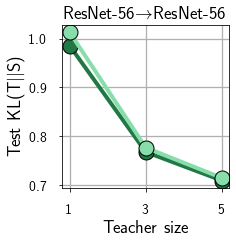

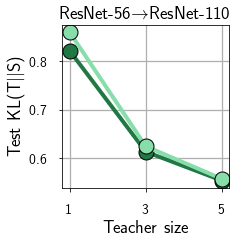

In [266]:
for name in df["name"].unique():
    ax = make_plot(df[df["name"]==name], "test_kl_ts", is_performance=False, with_teacher=False, with_baseline=True)
    ax.set_ylabel(r"Test KL(T$\vert\vert$S)", fontsize=18)
    ax.set_title(name, fontsize=18)
    plt.savefig("supp_{}_kl.pdf".format(name.replace("$\\rightarrow$", "-")), bbox_inches="tight")

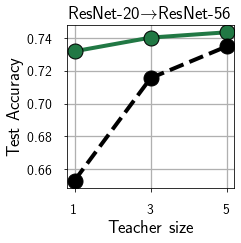

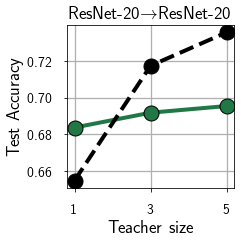

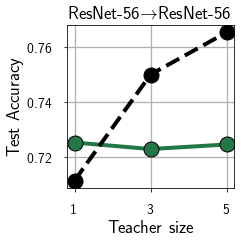

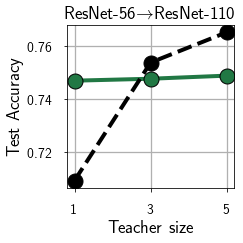

In [267]:
for name in df["name"].unique():
    ax = make_plot(df[df["name"]==name], "test_accuracy", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test Accuracy", fontsize=18)
    ax.set_title(name, fontsize=18)
    plt.savefig("supp_{}_acc.pdf".format(name.replace("$\\rightarrow$", "-")), bbox_inches="tight")

handles2 = ax.get_legend_handles_labels()

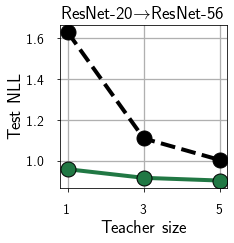

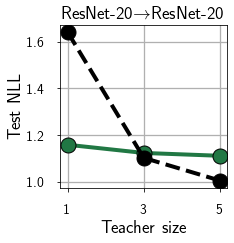

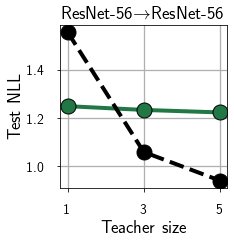

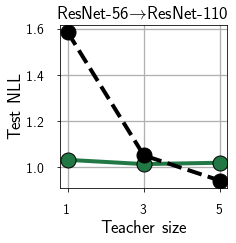

In [268]:
for name in df["name"].unique():
    ax = make_plot(df[df["name"]==name], "test_nll", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test NLL", fontsize=18)
    ax.set_title(name, fontsize=18)
    plt.savefig("supp_{}_nll.pdf".format(name.replace("$\\rightarrow$", "-")), bbox_inches="tight")


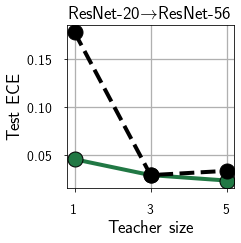

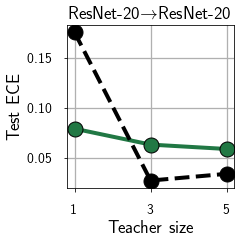

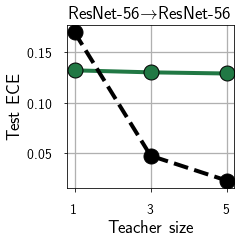

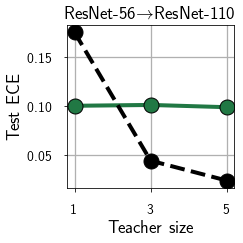

In [269]:
for name in df["name"].unique():
    ax = make_plot(df[df["name"]==name], "test_ece", is_performance=True, with_teacher=True, with_baseline=False)
    ax.set_ylabel(r"Test ECE", fontsize=18)
    ax.set_title(name, fontsize=18)
    plt.savefig("supp_{}_ece.pdf".format(name.replace("$\\rightarrow$", "-")), bbox_inches="tight")


In [272]:
df["name"].unique()

array(['ResNet-20$\\rightarrow$ResNet-56',
       'ResNet-20$\\rightarrow$ResNet-20',
       'ResNet-56$\\rightarrow$ResNet-56',
       'ResNet-56$\\rightarrow$ResNet-110'], dtype=object)

In [275]:
agree_str = "\includegraphics[height=0.15\\textwidth]{{figures/supp_{}_agreement.pdf}}"
kl_str = "\includegraphics[height=0.15\\textwidth]{{figures/supp_{}_kl.pdf}}"
acc_str = "\includegraphics[height=0.15\\textwidth]{{figures/supp_{}_acc.pdf}}"
nll_str = "\includegraphics[height=0.15\\textwidth]{{figures/supp_{}_nll.pdf}}"
ece_str = "\includegraphics[height=0.15\\textwidth]{{figures/supp_{}_ece.pdf}}"

strs = [acc_str, nll_str, ece_str, agree_str, kl_str]
names = [
        'ResNet-20$\\rightarrow$ResNet-20',
        'ResNet-20$\\rightarrow$ResNet-56',
        'ResNet-56$\\rightarrow$ResNet-56',
        'ResNet-56$\\rightarrow$ResNet-110']

for name in names:
    for row_str in strs:
#         endl = "\n" if name == r"ResNet-56$\rightarrow$ResNet-110" else " &\n"
        endl = "\n" if row_str == kl_str else " &\n"
        print(row_str.format(name.replace("$\\rightarrow$", "-")), end=endl)
    print("\\\\[-0.2cm]")
    

print(r"\multicolumn{5}{c}{\includegraphics[height=0.07\textwidth]{figures/supp_augs_legend}}")
print("\\\\[-0.2cm]")  

\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-20_acc.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-20_nll.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-20_ece.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-20_agreement.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-20_kl.pdf}
\\[-0.2cm]
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-56_acc.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-56_nll.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-56_ece.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-56_agreement.pdf} &
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-20-ResNet-56_kl.pdf}
\\[-0.2cm]
\includegraphics[height=0.15\textwidth]{figures/supp_ResNet-56-ResNet-56_acc.pdf} &
\includegraphics[height=0.15\textwidth]{figures/